# HDMA Washington State Data

About the data: The Home Mortgage Disclosure Act (HMDA) requires many financial institutions to maintain, report, and publicly disclose information about mortgages. These public data are important because they help show whether lenders are serving the housing needs of their communities; they give public officials information that helps them make decisions and policies; and they shed light on lending patterns that could be discriminatory.

Kaggle source: https://www.kaggle.com/miker400/washington-state-home-mortgage-hdma2016

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import pytz
import os
import scipy.stats as stat
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv("Washington_State_HDMA-2016.csv.zip", low_memory=False)

In [4]:
data.head()

tract_to_msamd_income  rate_spread  population  minority_population  \
0             121.690002          NaN      8381.0            23.790001   
1              83.370003          NaN      4915.0            23.990000   
2              91.129997          NaN      5075.0            11.820000   
3             146.169998          NaN      5032.0             8.590000   
4             162.470001          NaN      5183.0            10.500000   

   number_of_owner_occupied_units  number_of_1_to_4_family_units  \
0                          2175.0                         2660.0   
1                          1268.0                         1777.0   
2                          1136.0                         1838.0   
3                          1525.0                         1820.0   
4                          1705.0                         2104.0   

   loan_amount_000s  hud_median_family_income  applicant_income_000s  \
0               227                   73300.0                  116.0   
1               240                   57900.0                   42.0   
2               241                   73300.0                  117.0   
3               351                   73300.0                  315.0   
4               417                   78100.0                  114.0   

   state_name  ... applicant_sex_name  applicant_race_name_5  \
0  Washington  ...             Female                    NaN   
1  Washington  ...               Male                    NaN   
2  Washington  ...               Male                    NaN   
3  Washington  ...               Male                    NaN   
4  Washington  ...             Female                    NaN   

  applicant_race_name_4 applicant_race_name_3 applicant_race_name_2  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   

                               applicant_race_name_1  \
0  Information not provided by applicant in mail,...   
1                                              White   
2                                              White   
3  Information not provided by applicant in mail,...   
4                                              White   

                            applicant_ethnicity_name  \
0                             Not Hispanic or Latino   
1                                 Hispanic or Latino   
2                             Not Hispanic or Latino   
3  Information not provided by applicant in mail,...   
4                             Not Hispanic or Latino   

                                   agency_name agency_abbr action_taken_name  
0         Consumer Financial Protection Bureau        CFPB   Loan originated  
1  Department of Housing and Urban Development         HUD   Loan originated  
2  Department of Housing and Urban Development         HUD   Loan originated  
3         National Credit Union Administration        NCUA   Loan originated  
4        Federal Deposit Insurance Corporation        FDIC   Loan originated  

[5 rows x 47 columns]

In [5]:
data.shape

(466566, 47)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466566 entries, 0 to 466565
Data columns (total 47 columns):
tract_to_msamd_income             465951 non-null float64
rate_spread                       8638 non-null float64
population                        465956 non-null float64
minority_population               465956 non-null float64
number_of_owner_occupied_units    465944 non-null float64
number_of_1_to_4_family_units     465955 non-null float64
loan_amount_000s                  466566 non-null int64
hud_median_family_income          465960 non-null float64
applicant_income_000s             404533 non-null float64
state_name                        466566 non-null object
state_abbr                        466566 non-null object
sequence_number                   466566 non-null int64
respondent_id                     466566 non-null object
purchaser_type_name               466566 non-null object
property_type_name                466566 non-null object
preapproval_name              

In [7]:
data.action_taken_name.unique()

array(['Loan originated', 'Application approved but not accepted',
       'Application denied by financial institution',
       'Application withdrawn by applicant',
       'File closed for incompleteness',
       'Loan purchased by the institution',
       'Preapproval request denied by financial institution',
       'Preapproval request approved but not accepted'], dtype=object)

In [363]:
len(data)

466566

In [364]:
df = data.loc[(data.action_taken_name.str.contains('Loan originated'))
              | (data.action_taken_name.str.contains('Application denied by financial institution')) ]

## Visualizing missing data

In [9]:
plt.figure(figsize=(7,6))
sns.heatmap(df.isnull(), cbar=False)

In [10]:
df.edit_status_name.isnull().value_counts()

True     271594
False     56295
Name: edit_status_name, dtype: int64

In [11]:
removal_cols = df[['rate_spread','edit_status_name','denial_reason_name_2','co_applicant_race_name_5','co_applicant_race_name_4',
                  'co_applicant_race_name_3','co_applicant_race_name_2','applicant_race_name_5','applicant_race_name_4',
                  'applicant_race_name_3','applicant_race_name_2', 'denial_reason_name_1','denial_reason_name_3']]

In [370]:
df2=df.drop(columns=removal_cols)

In [13]:
plt.figure(figsize=(7,6))
sns.heatmap(df2.isnull(), cbar=False)

Rather than dropping the remaining columns that are missing, we will impute the missing values to preserve the observation

In [14]:
df2.loc[pd.isnull(df2).any(1)==True] #50,0444 observations have some missing value
null_test = df2.copy()
null_test.loc[(pd.isnull(null_test).any(1)==True)] # do these observations have something systematically similar about them?

tract_to_msamd_income  population  minority_population  \
5                  119.629997      4775.0            18.889999   
6                  103.209999      4745.0            33.070000   
7                   93.769997      7451.0            33.400002   
8                  109.580002      6567.0            21.709999   
26                  87.199997      5808.0            28.150000   
31                  59.689999      1686.0            33.930000   
32                 109.730003      5035.0            18.830000   
36                  99.269997      6786.0            35.340000   
38                  94.080002      5941.0            25.750000   
47                 112.559998      4333.0            16.570000   
54                 127.720001      5169.0             7.840000   
57                 112.559998      4333.0            16.570000   
60                  90.120003      8134.0            35.509998   
63                  70.739998      3361.0            18.510000   
87                 148.710007      4400.0             8.520000   
91                 110.930000      6131.0            31.690001   
92                 102.809998      6364.0            23.570000   
95                 132.619995      4683.0             8.140000   
101                111.809998      6773.0             8.890000   
103                 97.559998      5581.0            31.610001   
106                 74.540001      2806.0            12.870000   
116                 94.029999      3303.0            10.020000   
118                 96.970001      6149.0            21.030001   
129                 46.430000      6021.0            84.720001   
137                 99.750000      3803.0            30.549999   
139                 99.269997      6786.0            35.340000   
145                110.790001      4777.0            27.129999   
147                112.559998      4333.0            16.570000   
151                105.959999      6339.0             8.830000   
165                106.150001      7921.0            20.670000   
...                       ...         ...                  ...   
362653              67.089996      3652.0            28.920000   
362698             111.300003      4574.0            15.540000   
362703             127.730003      4395.0            13.010000   
362893              93.029999      5611.0            21.150000   
362933             113.889999      5683.0            10.430000   
363073             112.739998      3215.0            11.200000   
363143              79.300003      4921.0            28.670000   
363153              95.919998      7944.0            29.570000   
363188             126.739998      5781.0            11.870000   
363223              64.250000      4615.0            36.990002   
363268             128.690002      5609.0            16.760000   
363313              74.980003      5609.0            15.960000   
363318              95.919998      7944.0            29.570000   
363353              98.059998      6035.0            15.130000   
363363              87.410004      6123.0            23.219999   
363463              67.089996      3652.0            28.920000   
363473              92.839996      5422.0            14.290000   
363478             100.120003      5645.0            13.520000   
363483             112.739998      3215.0            11.200000   
363503             109.169998      4327.0            12.390000   
363563             123.709999      4639.0            14.770000   
363583              82.669998      3511.0            29.250000   
363628              85.349998      6029.0            22.139999   
363638             117.510002      4311.0            17.719999   
363668              73.690002      6804.0            22.879999   
363713              70.500000      2900.0            29.860001   
363723             175.889999      6641.0             9.560000   
363763             162.470001      5183.0            10.500000   
364148             101.639999      6252.0       

In [15]:
df2.loc[df2.msamd_name.isnull()].applicant_income_000s.isnull().value_counts(normalize=True) #msamd_name represents a metro division/area where the property is located in. 
# both msamd name and applicant income are missing 8% of the time. 

False    0.910565
True     0.089435
Name: applicant_income_000s, dtype: float64

In [16]:
df2.loc[(df2.applicant_income_000s.isnull())
       & (df2.msamd_name.isnull())] # appears as though half the time one is missing, so is the other... do these move together?

tract_to_msamd_income  population  minority_population  \
116                 94.029999      3303.0            10.020000   
420                 99.480003      2901.0            18.170000   
500                 86.660004      9912.0            39.060001   
556                106.550003      2694.0            10.130000   
575                135.029999      4359.0             7.480000   
585                106.339996      2825.0            72.389999   
665                 93.139999      8040.0            20.920000   
685                 86.660004      9912.0            39.060001   
886                 65.330002      6848.0            76.309998   
891                111.029999      4109.0            14.210000   
1035               126.940002      4989.0            15.010000   
1040               101.199997      5202.0             9.630000   
1045               122.739998      2608.0            10.770000   
1081               126.940002      4989.0            15.010000   
1095                71.660004      4448.0            28.799999   
1105                86.720001      3978.0             7.540000   
1110                97.519997      3771.0            12.620000   
1115                81.650002      6252.0            21.719999   
1175               148.710007      4400.0             8.520000   
1195               125.180000      4965.0            20.200001   
1200               107.279999      2475.0             9.540000   
1215               119.110001      3291.0            29.139999   
1220                71.739998      6803.0            17.200001   
1280               120.750000      5693.0             9.850000   
1310                92.870003      5703.0            23.990000   
1315               120.739998      4888.0            11.070000   
1325               148.710007      4400.0             8.520000   
1330               129.889999      3817.0             7.150000   
1335                86.660004      9912.0            39.060001   
1340               112.019997      2604.0            15.750000   
...                       ...         ...                  ...   
310142              95.250000      4267.0            23.110001   
310233             126.250000      4510.0             8.540000   
310288             106.980003      4255.0            12.830000   
310343             103.989998      2220.0             5.000000   
311052             138.029999      3394.0             6.280000   
314722              93.410004      3534.0            15.080000   
315487              98.930000      2995.0             9.650000   
315767              94.190002      1743.0             6.140000   
316322             132.289993      3819.0             9.450000   
316387              71.739998      6803.0            17.200001   
316487              82.389999      2856.0            70.660004   
316507              93.250000      7599.0            12.920000   
317587             132.289993      3819.0             9.450000   
317687             149.199997      5494.0            19.370001   
319382              71.739998      6803.0            17.200001   
319697              97.660004      3667.0             8.150000   
319772             130.679993      4855.0            15.550000   
319947             110.930000      6131.0            31.690001   
321387              71.169998      8325.0            13.810000   
324587             121.029999      4050.0             8.070000   
327522             101.199997      5202.0             9.630000   
327572              86.660004      9912.0            39.060001   
327632              81.800003      4095.0            16.190001   
327647             116.160004      4538.0            17.520000   
327742             107.169998      8817.0            12.030000   
328272             106.430000      4014.0            24.170000   
328347             105.959999      6339.0             8.830000   
329340             107.070000      2911.0             7.010000   
329827              94.190002      1743.0       

In [17]:
df2['missing_income'] = np.where((~df2.msamd_name.isnull()) & (df2.applicant_income_000s.isnull()),1,0)
df2['missing_msamd'] = np.where((~df2.applicant_income_000s.isnull()) & (df2.msamd_name.isnull()),1,0)
df2['missing_both'] = np.where((df2.msamd_name.isnull()) & (df2.applicant_income_000s.isnull()),1,0)

In [18]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327889 entries, 0 to 364323
Data columns (total 37 columns):
tract_to_msamd_income             327656 non-null float64
population                        327659 non-null float64
minority_population               327659 non-null float64
number_of_owner_occupied_units    327654 non-null float64
number_of_1_to_4_family_units     327658 non-null float64
loan_amount_000s                  327889 non-null int64
hud_median_family_income          327661 non-null float64
applicant_income_000s             301382 non-null float64
state_name                        327889 non-null object
state_abbr                        327889 non-null object
sequence_number                   327889 non-null int64
respondent_id                     327889 non-null object
purchaser_type_name               327889 non-null object
property_type_name                327889 non-null object
preapproval_name                  327889 non-null object
owner_occupancy_name         

In [19]:
pairs = df2[['action_taken_name','loan_amount_000s','hud_median_family_income','number_of_1_to_4_family_units',
            'number_of_owner_occupied_units','minority_population','population','tract_to_msamd_income','missing_income',
            'missing_msamd','missing_both']]
#sns.pairplot(pairs, hue='missing_income')

While some loose interpretations can be drawn from this, reasons for missing income, missing msamd, or missing both don't appear to be strongly related to any single other variable.
Cool to note: 
- normal distributions in tract to msamd income, population, number of owner occupied units, and number of 1-4 family units
- hud median family income appears bucketed at interval levels of income, with noticeable observations occurring in high-income areas ($90,000/household)


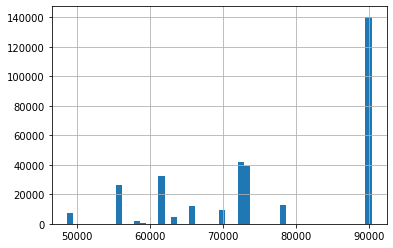

In [20]:
df2.hud_median_family_income.hist(bins=50)

In [21]:
df2.loc[df2.loan_amount_000s > 10000].loan_amount_000s.hist() #were these 156 entries with loan amounts over 10,000,000 miscodings? Or real loan amounts? How to best handle them? 

In [22]:
df2.loc[df2.loan_amount_000s > 10000].applicant_income_000s.describe() # the incomes for these individuals seem very typical. This is used as justification to replace these 156 values with the median loan amount

count       9.000000
mean      455.000000
std       848.268236
min        24.000000
25%        59.000000
50%        85.000000
75%       228.000000
max      2629.000000
Name: applicant_income_000s, dtype: float64

In [23]:
median = df2.loc[df2.loan_amount_000s < 10000].loan_amount_000s.median()

In [371]:
df2['loan_amount_000s'] = np.where(df2.loan_amount_000s >= 10000, median, df2['loan_amount_000s']) #replacing outliers with the median loan amount for the dataest

In [372]:
df2.loan_amount_000s.describe()

count    327889.000000
mean        288.929833
std         263.172755
min           1.000000
25%         172.000000
50%         248.000000
75%         350.000000
max        9951.000000
Name: loan_amount_000s, dtype: float64

### Assigning a unique identifier to each oberservation

In [373]:
import uuid

In [402]:
unique_identifier = []
for i in range(len(df2)):
    unique_identifier.append(uuid.uuid4())

df2['unique_identifier'] = unique_identifier

## Preprocessing

In [405]:
numeric = df2[['unique_identifier','tract_to_msamd_income','population','minority_population','number_of_owner_occupied_units'
              , 'number_of_1_to_4_family_units','loan_amount_000s','hud_median_family_income'
              , 'applicant_income_000s']]
categorical = df2[['unique_identifier','purchaser_type_name','property_type_name','preapproval_name','owner_occupancy_name',
                   'loan_type_name','loan_purpose_name','lien_status_name','hoepa_status_name','co_applicant_sex_name'
                  , 'co_applicant_race_name_1','co_applicant_ethnicity_name','application_date_indicator','applicant_sex_name'
                  ,'applicant_race_name_1','applicant_ethnicity_name','agency_name','msamd_name','action_taken_name']]

In [26]:
df2.info() #dropping respondent_id, sequence_number, as_of_year (all 2016), census_tract_number (redundant), missing_income, missing_msamd, missing_both
# state_name, state_abbr, repondent_id, 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327889 entries, 0 to 364323
Data columns (total 37 columns):
tract_to_msamd_income             327656 non-null float64
population                        327659 non-null float64
minority_population               327659 non-null float64
number_of_owner_occupied_units    327654 non-null float64
number_of_1_to_4_family_units     327658 non-null float64
loan_amount_000s                  327889 non-null float64
hud_median_family_income          327661 non-null float64
applicant_income_000s             301382 non-null float64
state_name                        327889 non-null object
state_abbr                        327889 non-null object
sequence_number                   327889 non-null int64
respondent_id                     327889 non-null object
purchaser_type_name               327889 non-null object
property_type_name                327889 non-null object
preapproval_name                  327889 non-null object
owner_occupancy_name       

In [365]:
categorical.msamd_name.value_counts(normalize=True)# nearly half the data is in one msamd_name, this justifies filling nulls with the name

Seattle, Bellevue, Everett - WA            0.465670
Tacoma, Lakewood - WA                      0.138233
Portland, Vancouver, Hillsboro - OR, WA    0.089976
Spokane, Spokane Valley - WA               0.073223
Bremerton, Silverdale - WA                 0.041669
Olympia, Tumwater - WA                     0.040671
Kennewick, Richland - WA                   0.038964
Bellingham - WA                            0.029999
Yakima - WA                                0.023530
Mount Vernon, Anacortes - WA               0.018149
Longview - WA                              0.015258
Wenatchee - WA                             0.015168
Walla Walla - WA                           0.006959
Lewiston - ID, WA                          0.002530
Name: msamd_name, dtype: float64

In [406]:
categorical= categorical.fillna(categorical.mode().iloc[:,-1])

In [407]:
categorical['loan_decision'] = np.where(categorical.action_taken_name == 'Loan originated', 0 , 1)

In [408]:
categorical.loan_decision.value_counts(normalize=True)

0    0.804272
1    0.195728
Name: loan_decision, dtype: float64

20% of mortgages in the sample data set were denied a loan

In [418]:
categorical.drop(['application_date_indicator'], axis=1, inplace=True)

In [429]:
categorical.drop(['action_taken_name'], axis=1, inplace=True)

In [431]:
categorical.iloc[:,1:17].columns

Index(['purchaser_type_name', 'property_type_name', 'preapproval_name',
       'owner_occupancy_name', 'loan_type_name', 'loan_purpose_name',
       'lien_status_name', 'hoepa_status_name', 'co_applicant_sex_name',
       'co_applicant_race_name_1', 'co_applicant_ethnicity_name',
       'applicant_sex_name', 'applicant_race_name_1',
       'applicant_ethnicity_name', 'agency_name', 'msamd_name'],
      dtype='object')

In [432]:
cols = list(categorical.iloc[:,1:17].columns)

In [433]:
cat_encode = pd.get_dummies(categorical, columns=cols)

In [436]:
prep_df = pd.merge(cat_encode, numeric, how='inner', on='unique_identifier')

## Random Forest Imputation of Missing Continuous Variables

In [115]:
from sklearn.ensemble import RandomForestRegressor

In [161]:
# Splitting to obs w/ income and those without income
null_data = prep_df[prep_df.isnull().any(axis=1)]
full_data = prep_df[prep_df.isnull().any(axis=1) == False]

In [162]:
fitter = RandomForestRegressor()

In [234]:
mask = full_data.drop(['tract_to_msamd_income', 'population', 'minority_population',
       'number_of_owner_occupied_units', 'number_of_1_to_4_family_units',
       'loan_amount_000s', 'hud_median_family_income',
       'applicant_income_000s', 'sequence_number'], axis=1).columns

In [455]:
# need an array of col indices for categorical column
prep_df.columns.get_loc('msamd_name_Yakima - WA') #86 87 88 89 91 92 col
indices = list(np.arange(0,85))

In [196]:
fitter.fit(full_data[mask], full_data[cols])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [197]:
imputed_vals= fitter.predict(X = null_data[mask])


In [200]:
cols

Index(['tract_to_msamd_income', 'population', 'minority_population',
       'number_of_owner_occupied_units', 'number_of_1_to_4_family_units',
       'hud_median_family_income', 'applicant_income_000s'],
      dtype='object')

In [210]:
full_data.tract_to_msamd_income.mean() # checking that values are correct columns

107.30871869456288

In [213]:
imputed = pd.DataFrame(imputed_vals)

In [216]:
imputed.rename({0: 'tract_to_msamd_income', 1: 'population', 2:'minority_population'
                                            , 3: 'number_of_owner_occupied_units', 4: 'number_of_1_to_4_family_units'
                                            , 5: 'hud_median_family_income', 6: 'applicant_income_000s'}, axis=1, inplace=True)

In [220]:
null_data[cols]= imputed

C:\Users\pdilm\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


## Imputing miss values using MissForest

In [443]:
from missingpy import MissForest

In [440]:
prep_df.loc[prep_df['population'].isnull() ==True]#.loan_decision.value_counts(normalize=True)

unique_identifier  loan_decision  \
1245    5a9c4b6e-92b4-446a-8649-6a3499432696              0   
1746    c308a4b4-b6e1-4c2b-a515-1cb9c95b83b6              0   
2651    336b20cd-f288-4b3a-b66f-dffb2efc12ae              0   
4016    3cb30be3-f300-409e-a1d5-0df52f1dcf61              0   
4946    8b660fb8-a2ac-418b-a2cf-954c56dd3d15              0   
5116    52f54593-3693-45ba-84a4-326dac976404              0   
5121    ee521ed1-bf4c-4a10-840b-3ac62b34630d              0   
5126    9709e823-a1d7-44c3-a918-b42b67cd01a3              0   
5216    a4a98f61-95cb-43d4-9358-5b9835febd2d              0   
7016    c5264ed3-97bd-4f15-8167-a2858e323ea7              0   
8241    0a980fdb-8849-4f35-ac74-393e5aec03f8              0   
8246    b45bb606-bb3d-4948-a4f6-4bdd2580819f              0   
8256    d905259f-bc03-44a4-8c0f-a4199f276157              0   
9791    58051941-c930-478d-9f4f-0212a8b8a574              0   
16554   24a1b63f-86a4-4a89-8193-a40b6a4efd4e              0   
16639   e21d3bd0-70bb-42c5-af78-c076bc909070              0   
19171   7b576205-86b2-43c9-9c85-32997ce7b06c              0   
23460   3c07182c-5040-4b4b-8d8a-424d88eec335              0   
23465   b3452e4a-31bf-4e59-bc4d-8def22c6c504              0   
23610   3816e30d-562b-4bd8-9150-244aecb75cbf              0   
24255   63a0f412-8cdb-4f5d-a880-85c6ce99fb5d              0   
24275   b730a53b-cf0c-42a0-8acd-d4d6e21449c9              0   
24290   0d5dd9c5-0309-4ab2-bdfe-c0e45f8c8747              0   
26675   4c71a0ba-b87b-448b-bbce-6dace24117ed              0   
27314   c86b4120-0f26-40a1-a8de-16e5273d3c26              0   
27319   ae2dfeb4-bef1-460e-a20a-4a30f5367896              0   
27324   a21f568d-be09-4a4b-82d7-4463c8afa272              0   
27329   f90ef27b-5bbe-4a0f-9885-0c5575dc13a1              0   
27683   e6964188-0936-4199-8205-7467681ff127              0   
28204   2fdbff52-912f-4b0a-9498-1cecf7cf6881              0   
...                                      ...            ...   
292783  7136e627-2cca-494a-bc40-a139158025a7              1   
292798  c23d6787-485a-4972-8efe-5d7eaa6e05f2              1   
293133  d55581e9-b2e5-4f5e-ab71-a7d8c5cbac32              1   
293328  ebc164c3-d5c6-4580-b1c9-08763950584b              1   
293348  002e1e78-ec89-4385-b986-a6fabc225b8f              1   
294318  cf322cef-bd3d-47b9-bc39-ebf45aaf2662              1   
294904  1a53f263-5f9e-4726-a36f-cca7dfecb043              1   
295039  3a61b7be-a8da-44c4-9c77-939102b9a435              1   
295044  79bc0b74-cb94-4447-9af1-7803c6ef87ec              1   
295108  394b4a5b-94fb-4752-9946-0623c81bd336              1   
295114  8cc7b6fe-7f9c-4593-9968-e313d694817e              1   
295638  445ab8c6-bbc5-4423-a740-9c65f20a6589              1   
295969  a3bfbc9c-9d23-47d0-884d-e618fc629f49              1   
296019  63ca0b76-f81f-49bb-a773-6ed34bf7ade0              1   
296272  4507bdd2-4b93-48d5-9a9e-54d30656dc6e              1   
296502  93676a11-3b38-4be4-8f94-028cf9553ec7              1   
297498  eb9d8ab5-87d9-4043-b627-469c42f081ba              1   
297538  b4085c07-dc2b-4b12-900d-515c5e2cf4f1              1   
297613  b28930ff-bacb-452f-b128-d5fab9e66979              1   
297618  4c546ff1-0930-41f1-80d6-f9e6cc8eef78              1   
297643  94718267-bb05-454e-9e55-f602184c7568              1   
297983  d660825a-9e47-4575-b052-8e7cce18aa85              1   
298618  3acc0494-8498-49a7-8df1-903910492d52              1   
303917  eab65316-40ff-4180-8923-19b8b8374466              1   
304477  7af182c2-1833-405e-abac-901553b53f08              1   
304771  49b362ff-c2fc-472c-88d1-7d89b1f85457              1   
304787  1ac7de30-efba-4da5-98c0-c93d1db30d73              1   
305443  232a0d62-5f79-4b2e-b430-31af08138b39              1   
310711  180652af-acb4-4da9-b951-7b902ca95bcc              1   
311066  e346f07d-e6c5-4d6e-a2a0-1d2fd77ad248              1   

        purchaser_type_name_Affiliate institution  \
1245                                            0   
1746          

In [441]:
230/len(prep_df)

0.0007014568954737732

Of the observations missing substantial amounts of data (n=230), 76% of them are for loans that were denied. This suggests that the missing data could be an inhibitor to getting a loan approved. Since these observations make up 0.07% of the total data, we are dropping the observations from the dataset. 

In [442]:
prep_df = prep_df.loc[~prep_df['population'].isnull()]

* note: population missing was arbitrarily chosen as the variable for deciding whether to keep the observations or not. When the population is missing, the other continuous variables appear to be systematically missing, therefore, "population" served as the filtering column.

In [480]:
column_names = prep_df.iloc[:,1:].columns

In [466]:
X= np.array(prep_df.iloc[:,1:])

In [467]:
imputer = MissForest()
x_imputed = imputer.fit_transform(X, cat_vars=np.array(indices))

C:\Users\pdilm\AppData\Local\Continuum\anaconda3\lib\site-packages\missingpy\missforest.py:407: RuntimeWarning: invalid value encountered in long_scalars
  (Ximp[:, self.cat_vars_] != Ximp_old[:, self.cat_vars_])) / n_catmissing


Iteration: 0


C:\Users\pdilm\AppData\Local\Continuum\anaconda3\lib\site-packages\missingpy\missforest.py:407: RuntimeWarning: invalid value encountered in long_scalars
  (Ximp[:, self.cat_vars_] != Ximp_old[:, self.cat_vars_])) / n_catmissing


Iteration: 1


C:\Users\pdilm\AppData\Local\Continuum\anaconda3\lib\site-packages\missingpy\missforest.py:407: RuntimeWarning: invalid value encountered in long_scalars
  (Ximp[:, self.cat_vars_] != Ximp_old[:, self.cat_vars_])) / n_catmissing


Iteration: 2


C:\Users\pdilm\AppData\Local\Continuum\anaconda3\lib\site-packages\missingpy\missforest.py:407: RuntimeWarning: invalid value encountered in long_scalars
  (Ximp[:, self.cat_vars_] != Ximp_old[:, self.cat_vars_])) / n_catmissing


Iteration: 3


In [481]:
df_imputed = pd.DataFrame(x_imputed, columns = column_names)

In [483]:
df_imputed['unique_identifier'] = prep_df['unique_identifier']

In [485]:
df_imputed.to_csv("imputed_loans.csv")

In [486]:
df_imputed

loan_decision  purchaser_type_name_Affiliate institution  \
0                 0.0                                        0.0   
1                 0.0                                        0.0   
2                 0.0                                        0.0   
3                 0.0                                        0.0   
4                 0.0                                        0.0   
5                 0.0                                        0.0   
6                 0.0                                        0.0   
7                 0.0                                        0.0   
8                 0.0                                        0.0   
9                 0.0                                        0.0   
10                0.0                                        0.0   
11                0.0                                        0.0   
12                0.0                                        0.0   
13                0.0                                        0.0   
14                0.0                                        0.0   
15                0.0                                        0.0   
16                0.0                                        0.0   
17                0.0                                        0.0   
18                0.0                                        0.0   
19                0.0                                        0.0   
20                0.0                                        0.0   
21                0.0                                        0.0   
22                0.0                                        0.0   
23                0.0                                        0.0   
24                0.0                                        0.0   
25                0.0                                        0.0   
26                0.0                                        0.0   
27                0.0                                        0.0   
28                0.0                                        0.0   
29                0.0                                        0.0   
...               ...                                        ...   
327629            1.0                                        0.0   
327630            1.0                                        0.0   
327631            1.0                                        0.0   
327632            1.0                                        0.0   
327633            1.0                                        0.0   
327634            1.0                                        0.0   
327635            1.0                                        0.0   
327636            1.0                                        0.0   
327637            1.0                                        0.0   
327638            1.0                                        0.0   
327639            1.0                                        0.0   
327640            1.0                                        0.0   
327641            1.0                                        0.0   
327642            1.0                                        0.0   
327643            1.0                                        0.0   
327644            1.0                                        0.0   
327645            1.0                                        0.0   
327646            1.0                                        0.0   
327647            1.0                                        0.0   
327648            1.0                                        0.0   
327649            1.0                                        0.0   
327650            1.0                                        0.0   
327651            1.0                                        0.0   
327652            1.0                                        0.0   
327653            1.0                                        0.0   
327654            1.0                                        0.0   
327655            1.0                                        0.0

### Normalizing continuous variables

In [496]:
cont_vars = df_imputed.iloc[:,85:93]

In [504]:
col_names = cont_vars.columns

In [497]:
scaled = StandardScaler()
cont_vars_sc = scaled.fit_transform(cont_vars)


In [506]:
continuous_z = pd.DataFrame(cont_vars_sc, columns = col_names)

In [519]:
scaled_df = df_imputed.iloc[:,:85].merge(continuous_z, how='inner', left_index=True, right_index=True)

In [525]:
scaled_df['loan_denied'] = scaled_df['loan_decision'].copy()

In [527]:
scaled_df.drop(columns=['loan_decision'], axis=1, inplace=True)

C:\Users\pdilm\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\pdilm\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


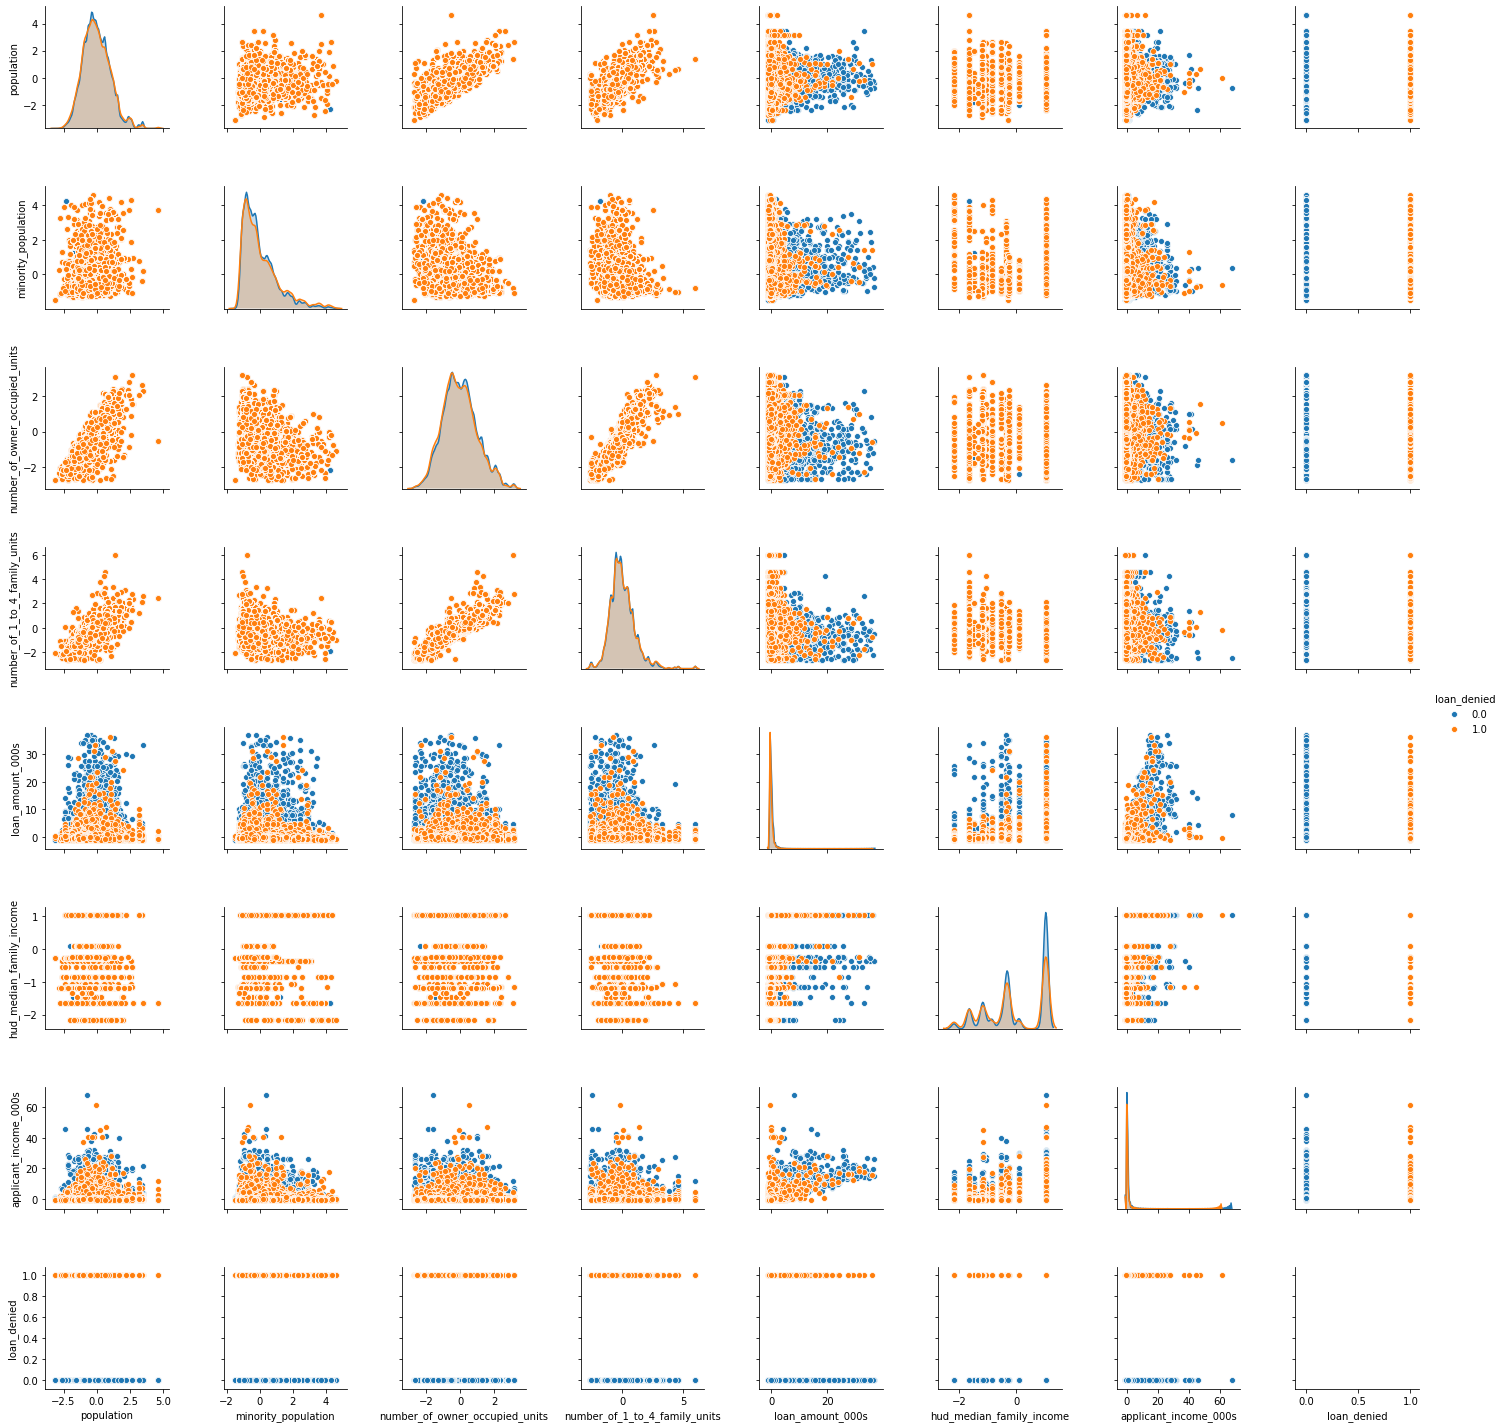

In [529]:
sns.pairplot(scaled_df.iloc[:,85:], hue='loan_denied')

In [532]:
x = scaled_df.iloc[:,:-1]
y = scaled_df.iloc[:,-1]

### Balancing the dependent variable using SMOTE

In [490]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [487]:
from imblearn.over_sampling import SMOTE # synthetic minority oversampling technique = artificially balancing out observations of the minority group by drawing feature vectors are creating new but similar observations
os= SMOTE(random_state=42)
from sklearn import metrics

In [488]:
df_imputed.loan_decision.value_counts(normalize=True)

0.0    0.804654
1.0    0.195346
Name: loan_decision, dtype: float64

- 20% loan denied

In [533]:
x_train,x_test, y_train, y_test = train_test_split(np.array(x),np.array(y), test_size = 0.25, random_state = 42 )

In [541]:
columns=x.columns
os_data_x,os_data_y=os.fit_sample(x_train, y_train)
os_data_x = pd.DataFrame(data=os_data_x,columns=columns)
os_data_y= pd.DataFrame(data=os_data_y,columns=['loan_denied'])

In [542]:
print("Number of approved loans in oversampled data",len(os_data_y[os_data_y['loan_denied']==0]))
print("Number of loan denied's in oversampled data",len(os_data_y[os_data_y['loan_denied']==1]))

Number of approved loans in oversampled data 197685
Number of loan denied's in oversampled data 197685


## Logistic Regression

In [543]:
logreg = LogisticRegression()

In [547]:
x = os_data_x
y = os_data_y

In [548]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.25, random_state = 42)

In [550]:
logreg.fit(x_train, y_train)

C:\Users\pdilm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\pdilm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [551]:
y_pred=logreg.predict(x_test)

In [553]:
logreg.score(x_test,y_test)

0.9065791204232976

In [554]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[41674  7895]
 [ 1339 47935]]


In [558]:
print(41674+7895+1339+47935), print(7895), print(1339/98843)

98843
7895
0.013546735732424148


(None, None, None)

- False negatives: 8% of observations are denied when they were, in fact, approved
- False positives: 1.3% of observations are approved when they were, in fact, denied

In [560]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.84      0.90     49569
         1.0       0.86      0.97      0.91     49274

    accuracy                           0.91     98843
   macro avg       0.91      0.91      0.91     98843
weighted avg       0.91      0.91      0.91     98843



In [561]:
from sklearn.metrics import roc_auc_score, roc_curve

In [564]:
logreg_roc = roc_auc_score(y_test, logreg.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(x_test)[:,1])
plt.figure(figsize=(7,5))

plt.plot(fpr,tpr, label='Logistic regression (area= %0.2f)' % logreg_roc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel("True positive rate")
plt.title("Receiver operating curve")
plt.legend(loc='best');

## Coeffificient Estimates & interpretation

In [565]:
import statsmodels.api as sm

In [580]:
cols = x.columns

In [589]:
coeffs = pd.DataFrame(logreg.coef_, columns = cols)

In [600]:
coeffs_df = pd.pivot_table(coeffs, columns=0).reset_index()

In [606]:
coeffs_df.rename(columns = {'index': 'Feature',0: 'coeff_est'}, inplace =True)

In [608]:
coeffs_df.loc[coeffs_df.coeff_est > 0]

Feature  coeff_est
1   agency_name_Department of Housing and Urban De...   1.192461
3                  agency_name_Federal Reserve System   0.872329
13    applicant_race_name_1_Black or African American   0.129578
19  applicant_sex_name_Information not provided by...   0.003908
29  co_applicant_race_name_1_Black or African Amer...   0.013131
52                  loan_type_name_FSA/RHS-guaranteed   0.319676
54                                minority_population   0.071573
58                       msamd_name_Lewiston - ID, WA   0.121491
64            msamd_name_Spokane, Spokane Valley - WA   0.002256
66                        msamd_name_Walla Walla - WA   0.115499
68                             msamd_name_Yakima - WA   0.182517
70                     number_of_owner_occupied_units   0.125829
79            property_type_name_Multifamily dwelling   0.111461
88  purchaser_type_name_Loan was not originated or...  10.029886

- If found to be significant, these factors increase the chance that a loan will get denied
- need to be transformed from log-odds to something more interpretable

### Rerunning with statsmodels Logit for better summary interpretability